# **PEML MLP Architecture 1 - computing physics output and feed in NN with regularisation**
## Experiment 1: y_phy calculated by linear time shifting according to wind speed and dist
### All years data

## **Running the models using the 'modelling' package**

A notebook through which different modelling configurations can be ran, using the ``modelling`` package. It follows the steps of:
- preparing packages;
- setting "global" variables;
- getting the data;
- defining hyperparameters;
- running a grid search and/or training a model; and
- evaluation.
In the modelling package, variations can be made to the models and training functions to experiment. Don't forget to restart the notebook after making changes there.



For loading models, go to the ``src/results/models``:
- Baseline NO2 2017 with MLP and MSE loss: ``best_mlp_no2_baseline_2017.pth``


In [1]:
print("Starting script...")


from modelling.MLP import BasicMLP
from modelling import *


import optuna
import threading
import os
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

Starting script...

Running __init__.py for data pipeline...
Modelling package initialized



Use GPU when available

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cpu


### **Set "global" variables**

In [3]:
Path.cwd()

PosixPath('/home/rachel/forecasting_smog_PEML/src')

In [4]:
import importlib
import config
importlib.reload(config)

<module 'config' from '/home/rachel/forecasting_smog_PEML/src/config.py'>

In [5]:
from config import *

In [6]:
HABROK = bool(0)                  # set to True if using HABROK; it will print
                                  # all stdout to a .txt file to log progress


print("BASE_DIR: ", BASE_DIR)
print("MODEL_PATH: ", MODEL_PATH)
print("Results path: ", RESULTS_PATH)

torch.manual_seed(34)             # set seed for reproducibility


BASE_DIR:  /home/rachel/forecasting_smog_PEML
MODEL_PATH:  /home/rachel/forecasting_smog_PEML/src/results/models
Results path:  /home/rachel/forecasting_smog_PEML/src/results



## MODIFY THESE GLOBAL VARIABLES FOR YOUR MODEL SCENARIO
## all other variables are defined in config.py

In [7]:
# Change this according to the data you want to use
YEARS = [2017, 2018, 2020, 2021, 2022, 2023]
TRAIN_YEARS = [2017, 2018, 2020, 2021, 2022]
VAL_YEARS = [2021, 2022, 2023]
TEST_YEARS = [2021, 2022, 2023]

LOSS_FUNC = "LinearShift_MSE"
NN_TYPE = "MLP" # choose from "MLP", "RNN", "LSTM", "GRU"
torch.random.manual_seed(34)

In [8]:
if YEARS == [2017, 2018, 2020, 2021, 2022, 2023]:
    years = "allyears"
    MINMAX_PATH = MINMAX_PATH_ALLYEARS
    DATASET_PATH = DATASET_PATH_ALLYEARS
    
    print("Using all years")
    
elif YEARS == [2017]:
    years = "2017"
    MINMAX_PATH = MINMAX_PATH_2017
    DATASET_PATH = DATASET_PATH_2017
    print("Using 2017")
else:
    raise ValueError("Invalid years selected")


MODEL_PATH_NAME = f'best_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.pth'
RESULTS_METRICS_FILENAME = f'results_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.csv'
BESTPARAMS_FILENAME = f'best_params_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.txt'
PLOT_FILENAME = f'plot_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.png'
print("MINMAX_PATH: ", MINMAX_PATH)
print("DATASET_PATH: ", DATASET_PATH)
print("MODEL_PATH_NAME: ", MODEL_PATH_NAME)
print("RESULTS_METRICS_FILENAME: ", RESULTS_METRICS_FILENAME)
print("BESTPARAMS_FILENAME: ", BESTPARAMS_FILENAME)
print("PLOT_FILENAME: ", PLOT_FILENAME)

Using all years
MINMAX_PATH:  /home/rachel/forecasting_smog_PEML/data/data_combined/all_years/pollutants_minmax_allyears.csv
DATASET_PATH:  /home/rachel/forecasting_smog_PEML/data/data_combined/all_years
MODEL_PATH_NAME:  best_MLP_no2_LinearShift_MSE_allyears.pth
RESULTS_METRICS_FILENAME:  results_MLP_no2_LinearShift_MSE_allyears.csv
BESTPARAMS_FILENAME:  best_params_MLP_no2_LinearShift_MSE_allyears.txt
PLOT_FILENAME:  plot_MLP_no2_LinearShift_MSE_allyears.png


### **Load in data and create PyTorch *Datasets***

In [9]:
# Load in data and create PyTorch Datasets. To tune
# which exact .csv files get extracted, change the
# lists in the get_dataframes() definition

train_input_frames = get_dataframes('train', 'u', YEARS, DATASET_PATH)
train_output_frames = get_dataframes('train', 'y', YEARS, DATASET_PATH)

val_input_frames = get_dataframes('val', 'u', YEARS, DATASET_PATH)
val_output_frames = get_dataframes('val', 'y', YEARS, DATASET_PATH)

test_input_frames = get_dataframes('test', 'u', YEARS, DATASET_PATH)
test_output_frames = get_dataframes('test', 'y', YEARS, DATASET_PATH)

print("Successfully loaded data")

Imported train_2017_combined_u.csv
Imported train_2018_combined_u.csv
Imported train_2020_combined_u.csv
Imported train_2021_combined_u.csv
Imported train_2022_combined_u.csv
Imported train_2017_combined_y.csv
Imported train_2018_combined_y.csv
Imported train_2020_combined_y.csv
Imported train_2021_combined_y.csv
Imported train_2022_combined_y.csv
Imported val_2021_combined_u.csv
Imported val_2022_combined_u.csv
Imported val_2023_combined_u.csv
Imported val_2021_combined_y.csv
Imported val_2022_combined_y.csv
Imported val_2023_combined_y.csv
Imported test_2021_combined_u.csv
Imported test_2022_combined_u.csv
Imported test_2023_combined_u.csv
Imported test_2021_combined_y.csv
Imported test_2022_combined_y.csv
Imported test_2023_combined_y.csv
Successfully loaded data


In [10]:
train_input_frames

[                           DD        FF        FH        FX  NO2_BREUKELEN  \
 DateTime                                                                     
 2017-08-01 00:00:00  0.166667  0.083333  0.083333  0.043478       0.207556   
 2017-08-01 01:00:00  0.000000  0.000000  0.083333  0.086957       0.140351   
 2017-08-01 02:00:00  0.000000  0.000000  0.000000  0.043478       0.252483   
 2017-08-01 03:00:00  0.277778  0.083333  0.000000  0.043478       0.379467   
 2017-08-01 04:00:00  0.805556  0.166667  0.083333  0.130435       0.426715   
 ...                       ...       ...       ...       ...            ...   
 2017-12-30 19:00:00  0.694444  0.416667  0.416667  0.478261       0.201615   
 2017-12-30 20:00:00  0.694444  0.416667  0.333333  0.434783       0.217859   
 2017-12-30 21:00:00  0.666667  0.333333  0.416667  0.434783       0.221480   
 2017-12-30 22:00:00  0.694444  0.250000  0.250000  0.304348       0.209505   
 2017-12-30 23:00:00  0.666667  0.416667  0.250000  

In [11]:
train_dataset = TimeSeriesDataset(
    train_input_frames,  # list of input training dataframes
    train_output_frames, # list of output training dataframes
    len(TRAIN_YEARS),                   # number of dataframes put in for both
                         # (basically len(train_input_frames) and
                         # len(train_output_frames) must be equal)
    N_HOURS_U,           # number of hours of input data
    N_HOURS_Y,           # number of hours of output data
    N_HOURS_STEP,        # number of hours between each input/output pair
)
val_dataset = TimeSeriesDataset(
    val_input_frames,    # etc.
    val_output_frames,
    len(VAL_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)
test_dataset = TimeSeriesDataset(
    test_input_frames,
    test_output_frames,
    len(TEST_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)

del train_input_frames, train_output_frames
del val_input_frames, val_output_frames
del test_input_frames, test_output_frames

In [12]:
train_dataset.u

[                           DD        FF        FH        FX  NO2_BREUKELEN  \
 DateTime                                                                     
 2017-08-01 00:00:00  0.166667  0.083333  0.083333  0.043478       0.207556   
 2017-08-01 01:00:00  0.000000  0.000000  0.083333  0.086957       0.140351   
 2017-08-01 02:00:00  0.000000  0.000000  0.000000  0.043478       0.252483   
 2017-08-01 03:00:00  0.277778  0.083333  0.000000  0.043478       0.379467   
 2017-08-01 04:00:00  0.805556  0.166667  0.083333  0.130435       0.426715   
 ...                       ...       ...       ...       ...            ...   
 2017-12-30 19:00:00  0.694444  0.416667  0.416667  0.478261       0.201615   
 2017-12-30 20:00:00  0.694444  0.416667  0.333333  0.434783       0.217859   
 2017-12-30 21:00:00  0.666667  0.333333  0.416667  0.434783       0.221480   
 2017-12-30 22:00:00  0.694444  0.250000  0.250000  0.304348       0.209505   
 2017-12-30 23:00:00  0.666667  0.416667  0.250000  

In [13]:
train_dataset.y

[                          NO2
 DateTime                     
 2017-08-01 00:00:00  0.207556
 2017-08-01 01:00:00  0.140351
 2017-08-01 02:00:00  0.252483
 2017-08-01 03:00:00  0.379467
 2017-08-01 04:00:00  0.426715
 ...                       ...
 2017-12-30 19:00:00  0.201615
 2017-12-30 20:00:00  0.217859
 2017-12-30 21:00:00  0.221480
 2017-12-30 22:00:00  0.209505
 2017-12-30 23:00:00  0.240787
 
 [3648 rows x 1 columns],
                           NO2
 DateTime                     
 2018-08-01 00:00:00  0.572728
 2018-08-01 01:00:00  0.490485
 2018-08-01 02:00:00  0.511928
 2018-08-01 03:00:00  0.430428
 2018-08-01 04:00:00  0.387450
 ...                       ...
 2018-12-30 19:00:00  0.273554
 2018-12-30 20:00:00  0.245336
 2018-12-30 21:00:00  0.189548
 2018-12-30 22:00:00  0.169312
 2018-12-30 23:00:00  0.124478
 
 [3648 rows x 1 columns],
                           NO2
 DateTime                     
 2020-08-01 00:00:00  0.115845
 2020-08-01 01:00:00  0.173953
 2020-08-01 02

In [14]:
len(train_dataset.pairs[0][0])

72

In [15]:
train_dataset.pairs[0][0]

tensor([[0.1667, 0.0833, 0.0833, 0.0435, 0.2076, 0.2234, 0.6349, 0.0000, 0.4974,
         0.7230],
        [0.0000, 0.0000, 0.0833, 0.0870, 0.1404, 0.2071, 0.6392, 0.0000, 0.5053,
         0.7338],
        [0.0000, 0.0000, 0.0000, 0.0435, 0.2525, 0.1579, 0.6335, 0.0000, 0.4735,
         0.6942],
        [0.2778, 0.0833, 0.0000, 0.0435, 0.3795, 0.1377, 0.6307, 0.0000, 0.4392,
         0.6511],
        [0.8056, 0.1667, 0.0833, 0.1304, 0.4267, 0.1496, 0.6307, 0.0000, 0.4630,
         0.6727],
        [0.0000, 0.0000, 0.0833, 0.1304, 0.4310, 0.2847, 0.6378, 0.3000, 0.5635,
         0.7482],
        [0.7222, 0.0833, 0.0833, 0.0870, 0.3823, 0.4730, 0.6506, 0.0000, 0.5820,
         0.7230],
        [0.7500, 0.0833, 0.0833, 0.1304, 0.3783, 0.4766, 0.6520, 0.0000, 0.5873,
         0.7050],
        [0.7222, 0.1667, 0.1667, 0.1304, 0.3354, 0.4598, 0.6534, 0.0000, 0.6058,
         0.6691],
        [0.7500, 0.1667, 0.1667, 0.2174, 0.3959, 0.3985, 0.6548, 0.3000, 0.6376,
         0.6367],
        [0

In [16]:
train_dataset.pairs[0][1]

tensor([[0.1842],
        [0.1443],
        [0.1457],
        [0.2406],
        [0.4900],
        [0.4313],
        [0.3199],
        [0.2520],
        [0.1827],
        [0.1643],
        [0.1446],
        [0.1315],
        [0.0821],
        [0.1171],
        [0.1264],
        [0.1217],
        [0.1050],
        [0.1010],
        [0.0851],
        [0.0860],
        [0.1145],
        [0.0873],
        [0.0643],
        [0.1017]])

In [17]:
# Assuming train_dataset.u[0] is a pandas Index object with column names
column_names = list(train_dataset.u[0])  # Convert Index to list


print("No2 tuindorp idx: ", column_names.index('NO2_TUINDORP'))
print("No2 breukelen idx: ", column_names.index('NO2_BREUKELEN'))
print("wind dir (dd) idx: ", column_names.index('DD'))
print("wind speed (fh) idx: ", column_names.index('FH'))

# check if the indices are the same as whats defined in config.py
assert column_names.index('NO2_TUINDORP')== NO2_TUINDORP_IDX
assert column_names.index('NO2_BREUKELEN') == NO2_BREUKELEN_IDX
assert column_names.index('DD') == WIND_DIR_IDX
assert column_names.index('FH') == WIND_SPEED_IDX
print("Column indices are same as config.py")



No2 tuindorp idx:  5
No2 breukelen idx:  4
wind dir (dd) idx:  0
wind speed (fh) idx:  2
Column indices are same as config.py


In [18]:
train_dataset.u[0].iloc[:,NO2_TUINDORP_IDX]

DateTime
2017-08-01 00:00:00    0.223383
2017-08-01 01:00:00    0.207092
2017-08-01 02:00:00    0.157895
2017-08-01 03:00:00    0.137659
2017-08-01 04:00:00    0.149633
                         ...   
2017-12-30 19:00:00    0.168848
2017-12-30 20:00:00    0.140072
2017-12-30 21:00:00    0.191033
2017-12-30 22:00:00    0.147406
2017-12-30 23:00:00    0.158823
Name: NO2_TUINDORP, Length: 3648, dtype: float64

In [19]:
train_dataset.u[0].iloc[:,NO2_BREUKELEN_IDX]

DateTime
2017-08-01 00:00:00    0.207556
2017-08-01 01:00:00    0.140351
2017-08-01 02:00:00    0.252483
2017-08-01 03:00:00    0.379467
2017-08-01 04:00:00    0.426715
                         ...   
2017-12-30 19:00:00    0.201615
2017-12-30 20:00:00    0.217859
2017-12-30 21:00:00    0.221480
2017-12-30 22:00:00    0.209505
2017-12-30 23:00:00    0.240787
Name: NO2_BREUKELEN, Length: 3648, dtype: float64

In [20]:
train_dataset.u[0].iloc[:,WIND_DIR_IDX]

DateTime
2017-08-01 00:00:00    0.166667
2017-08-01 01:00:00    0.000000
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.277778
2017-08-01 04:00:00    0.805556
                         ...   
2017-12-30 19:00:00    0.694444
2017-12-30 20:00:00    0.694444
2017-12-30 21:00:00    0.666667
2017-12-30 22:00:00    0.694444
2017-12-30 23:00:00    0.666667
Name: DD, Length: 3648, dtype: float64

In [21]:
train_dataset.u[0].iloc[:,WIND_SPEED_IDX]

DateTime
2017-08-01 00:00:00    0.083333
2017-08-01 01:00:00    0.083333
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.000000
2017-08-01 04:00:00    0.083333
                         ...   
2017-12-30 19:00:00    0.416667
2017-12-30 20:00:00    0.333333
2017-12-30 21:00:00    0.416667
2017-12-30 22:00:00    0.250000
2017-12-30 23:00:00    0.250000
Name: FH, Length: 3648, dtype: float64

## Tuning Hyperparamters

In [22]:
print("tuning with loss function: ", LOSS_FUNC)
print("tuning with nn type: ", NN_TYPE)

tuning with loss function:  LinearShift_MSE
tuning with nn type:  MLP


In [23]:
def objective(trial):
    # Define hyperparameters to search over
    n_hidden_layers = trial.suggest_int("n_hidden_layers", 1, 5)
    n_hidden_units = trial.suggest_int("n_hidden_units", 32, 256)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64]) 
    lambda_phy = trial.suggest_loguniform("lambda_phy", 1e-5, 1e-1)

    # Create train & validation loaders (following the original code)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize MLP model
    model = BasicMLP(
        N_INPUT_UNITS=train_dataset.__n_features_in__(),
        N_HIDDEN_LAYERS=n_hidden_layers,
        N_HIDDEN_UNITS=n_hidden_units,
        N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
        loss_function=LOSS_FUNC,
    )

    # Train and return validation loss
    val_loss, _ = model.train_model(train_loader, val_loader, epochs=50, lr=lr, weight_decay=weight_decay, lambda_phy=lambda_phy, device=device)
    
    return val_loss


# Run Optuna optimization
study = optuna.create_study(direction="minimize", study_name="mlp_hyperparameter_optimization_linearshift_mse_allyears", storage="sqlite:///mlp_hyperparameter_optimization_phy.db", load_if_exists=True)

study.optimize(objective, n_trials=50)

# Print best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2025-03-23 13:01:13,906] A new study created in RDB with name: mlp_hyperparameter_optimization_linearshift_mse_allyears
/tmp/ipykernel_12613/2082688131.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
/tmp/ipykernel_12613/2082688131.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)
/tmp/ipykernel_12613/2082688131.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_phy = trial.suggest

Epoch 1/50
Epoch 1/50 - Train Loss: 0.015932 - Val Loss (simple RMSE, no physics involved): 0.074919
Epoch 2/50
Epoch 2/50 - Train Loss: 0.007464 - Val Loss (simple RMSE, no physics involved): 0.070691
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007257 - Val Loss (simple RMSE, no physics involved): 0.074675
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007108 - Val Loss (simple RMSE, no physics involved): 0.071011
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007123 - Val Loss (simple RMSE, no physics involved): 0.068931
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007213 - Val Loss (simple RMSE, no physics involved): 0.066955
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007133 - Val Loss (simple RMSE, no physics involved): 0.069343
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007066 - Val Loss (simple RMSE, no physics involved): 0.071833
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007192 - Val Loss (simple RMSE, no physics involved): 0.068072
Epoch 10/50
Epoch 10/50 - Train Loss: 0.007021 - Val Loss (simple RMSE, no physics involved

[I 2025-03-23 13:06:27,361] Trial 0 finished with value: 0.06499167283376057 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 211, 'lr': 0.0007373374686952379, 'weight_decay': 3.5793194295136316e-05, 'batch_size': 8, 'lambda_phy': 3.081287066241128e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 1/50
Epoch 1/50 - Train Loss: 0.054261 - Val Loss (simple RMSE, no physics involved): 0.162174
Epoch 2/50
Epoch 2/50 - Train Loss: 0.048371 - Val Loss (simple RMSE, no physics involved): 0.150011
Epoch 3/50
Epoch 3/50 - Train Loss: 0.042763 - Val Loss (simple RMSE, no physics involved): 0.138157
Epoch 4/50
Epoch 4/50 - Train Loss: 0.037473 - Val Loss (simple RMSE, no physics involved): 0.127002
Epoch 5/50
Epoch 5/50 - Train Loss: 0.032604 - Val Loss (simple RMSE, no physics involved): 0.117691
Epoch 6/50
Epoch 6/50 - Train Loss: 0.028439 - Val Loss (simple RMSE, no physics involved): 0.110965
Epoch 7/50
Epoch 7/50 - Train Loss: 0.025048 - Val Loss (simple RMSE, no physics involved): 0.107497
Epoch 8/50
Epoch 8/50 - Train Loss: 0.022576 - Val Loss (simple RMSE, no physics involved): 0.106860
Epoch 9/50
Epoch 9/50 - Train Loss: 0.020917 - Val Loss (simple RMSE, no physics involved): 0.107967
Epoch 10/50
Epoch 10/50 - Train Loss: 0.019886 - Val Loss (simple RMSE, no physics involved

[I 2025-03-23 13:09:03,727] Trial 1 finished with value: 0.07515470311045647 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 54, 'lr': 1.531611130579815e-05, 'weight_decay': 2.4929254251452253e-05, 'batch_size': 8, 'lambda_phy': 0.013349638195138788}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.008439 - Val Loss (simple RMSE, no physics involved): 0.075155
Epoch 1/50
Epoch 1/50 - Train Loss: 0.062216 - Val Loss (simple RMSE, no physics involved): 0.110583
Epoch 2/50
Epoch 2/50 - Train Loss: 0.022743 - Val Loss (simple RMSE, no physics involved): 0.137057
Epoch 3/50
Epoch 3/50 - Train Loss: 0.018409 - Val Loss (simple RMSE, no physics involved): 0.109441
Epoch 4/50
Epoch 4/50 - Train Loss: 0.016288 - Val Loss (simple RMSE, no physics involved): 0.105696
Epoch 5/50
Epoch 5/50 - Train Loss: 0.012585 - Val Loss (simple RMSE, no physics involved): 0.084582
Epoch 6/50
Epoch 6/50 - Train Loss: 0.009528 - Val Loss (simple RMSE, no physics involved): 0.075153
Epoch 7/50
Epoch 7/50 - Train Loss: 0.008527 - Val Loss (simple RMSE, no physics involved): 0.073817
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007959 - Val Loss (simple RMSE, no physics involved): 0.073288
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007627 - Val Loss (simple RMSE, no physics involved): 0.072832


[I 2025-03-23 13:10:10,519] Trial 2 finished with value: 0.06631694734096527 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 155, 'lr': 0.0004888794137698953, 'weight_decay': 9.284624552988477e-08, 'batch_size': 64, 'lambda_phy': 0.008661939958391028}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006776 - Val Loss (simple RMSE, no physics involved): 0.069463
Epoch 1/50
Epoch 1/50 - Train Loss: 0.039837 - Val Loss (simple RMSE, no physics involved): 0.111184
Epoch 2/50
Epoch 2/50 - Train Loss: 0.012742 - Val Loss (simple RMSE, no physics involved): 0.083317
Epoch 3/50
Epoch 3/50 - Train Loss: 0.008467 - Val Loss (simple RMSE, no physics involved): 0.072550
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007794 - Val Loss (simple RMSE, no physics involved): 0.074391
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007521 - Val Loss (simple RMSE, no physics involved): 0.069855
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007381 - Val Loss (simple RMSE, no physics involved): 0.068457
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007380 - Val Loss (simple RMSE, no physics involved): 0.069035
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007329 - Val Loss (simple RMSE, no physics involved): 0.067690
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007396 - Val Loss (simple RMSE, no physics involved): 0.072532


[I 2025-03-23 13:11:22,467] Trial 3 finished with value: 0.06665714395542939 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 39, 'lr': 0.0009321403522552886, 'weight_decay': 0.0002743682638618613, 'batch_size': 16, 'lambda_phy': 2.0526750174374002e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.007110 - Val Loss (simple RMSE, no physics involved): 0.066866
Epoch 1/50
Epoch 1/50 - Train Loss: 0.092795 - Val Loss (simple RMSE, no physics involved): 0.224632
Epoch 2/50
Epoch 2/50 - Train Loss: 0.084221 - Val Loss (simple RMSE, no physics involved): 0.210427
Epoch 3/50
Epoch 3/50 - Train Loss: 0.075823 - Val Loss (simple RMSE, no physics involved): 0.195668
Epoch 4/50
Epoch 4/50 - Train Loss: 0.067437 - Val Loss (simple RMSE, no physics involved): 0.180017
Epoch 5/50
Epoch 5/50 - Train Loss: 0.058754 - Val Loss (simple RMSE, no physics involved): 0.162722
Epoch 6/50
Epoch 6/50 - Train Loss: 0.049745 - Val Loss (simple RMSE, no physics involved): 0.143800
Epoch 7/50
Epoch 7/50 - Train Loss: 0.040670 - Val Loss (simple RMSE, no physics involved): 0.124805
Epoch 8/50
Epoch 8/50 - Train Loss: 0.031710 - Val Loss (simple RMSE, no physics involved): 0.110490
Epoch 9/50
Epoch 9/50 - Train Loss: 0.025225 - Val Loss (simple RMSE, no physics involved): 0.107452


[I 2025-03-23 13:13:13,758] Trial 4 finished with value: 0.07122332789003849 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 71, 'lr': 2.7209433202332614e-05, 'weight_decay': 2.9665279001332357e-08, 'batch_size': 16, 'lambda_phy': 0.0761186980967188}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.009056 - Val Loss (simple RMSE, no physics involved): 0.072367
Epoch 1/50
Epoch 1/50 - Train Loss: 0.029272 - Val Loss (simple RMSE, no physics involved): 0.088666
Epoch 2/50
Epoch 2/50 - Train Loss: 0.010882 - Val Loss (simple RMSE, no physics involved): 0.076047
Epoch 3/50
Epoch 3/50 - Train Loss: 0.008353 - Val Loss (simple RMSE, no physics involved): 0.077487
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007831 - Val Loss (simple RMSE, no physics involved): 0.073883
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007491 - Val Loss (simple RMSE, no physics involved): 0.071469
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007360 - Val Loss (simple RMSE, no physics involved): 0.073377
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007220 - Val Loss (simple RMSE, no physics involved): 0.068954
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007185 - Val Loss (simple RMSE, no physics involved): 0.070069
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007137 - Val Loss (simple RMSE, no physics involved): 0.069271


[I 2025-03-23 13:14:37,019] Trial 5 finished with value: 0.06631120170156161 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 169, 'lr': 0.0008210547457074133, 'weight_decay': 9.18153319933937e-07, 'batch_size': 32, 'lambda_phy': 0.004984448953423662}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006728 - Val Loss (simple RMSE, no physics involved): 0.068138
Epoch 1/50
Epoch 1/50 - Train Loss: 0.025932 - Val Loss (simple RMSE, no physics involved): 0.125265
Epoch 2/50
Epoch 2/50 - Train Loss: 0.009868 - Val Loss (simple RMSE, no physics involved): 0.074196
Epoch 3/50
Epoch 3/50 - Train Loss: 0.008341 - Val Loss (simple RMSE, no physics involved): 0.080922
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007919 - Val Loss (simple RMSE, no physics involved): 0.073705
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007531 - Val Loss (simple RMSE, no physics involved): 0.072090
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007338 - Val Loss (simple RMSE, no physics involved): 0.072029
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007431 - Val Loss (simple RMSE, no physics involved): 0.073390
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007221 - Val Loss (simple RMSE, no physics involved): 0.072257
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007525 - Val Loss (simple RMSE, no physics involved): 0.071056


[I 2025-03-23 13:15:31,184] Trial 6 finished with value: 0.06778349354863167 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 121, 'lr': 0.006845107889957535, 'weight_decay': 0.0007393651179388028, 'batch_size': 64, 'lambda_phy': 2.2088780901933665e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.007155 - Val Loss (simple RMSE, no physics involved): 0.068792
Epoch 1/50
Epoch 1/50 - Train Loss: 0.024643 - Val Loss (simple RMSE, no physics involved): 0.116947
Epoch 2/50
Epoch 2/50 - Train Loss: 0.016334 - Val Loss (simple RMSE, no physics involved): 0.098126
Epoch 3/50
Epoch 3/50 - Train Loss: 0.012947 - Val Loss (simple RMSE, no physics involved): 0.086719
Epoch 4/50
Epoch 4/50 - Train Loss: 0.010352 - Val Loss (simple RMSE, no physics involved): 0.076969
Epoch 5/50
Epoch 5/50 - Train Loss: 0.008833 - Val Loss (simple RMSE, no physics involved): 0.074130
Epoch 6/50
Epoch 6/50 - Train Loss: 0.008127 - Val Loss (simple RMSE, no physics involved): 0.071529
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007833 - Val Loss (simple RMSE, no physics involved): 0.072409
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007685 - Val Loss (simple RMSE, no physics involved): 0.069835
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007607 - Val Loss (simple RMSE, no physics involved): 0.069432


[I 2025-03-23 13:19:15,838] Trial 7 finished with value: 0.06616523768752813 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 210, 'lr': 3.162185934312986e-05, 'weight_decay': 1.1922255592006932e-05, 'batch_size': 8, 'lambda_phy': 0.012528424462493193}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.007044 - Val Loss (simple RMSE, no physics involved): 0.067862
Epoch 1/50
Epoch 1/50 - Train Loss: 0.025474 - Val Loss (simple RMSE, no physics involved): 0.092089
Epoch 2/50
Epoch 2/50 - Train Loss: 0.009276 - Val Loss (simple RMSE, no physics involved): 0.082399
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007889 - Val Loss (simple RMSE, no physics involved): 0.072957
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007515 - Val Loss (simple RMSE, no physics involved): 0.073209
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007541 - Val Loss (simple RMSE, no physics involved): 0.069631
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007326 - Val Loss (simple RMSE, no physics involved): 0.069737
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007283 - Val Loss (simple RMSE, no physics involved): 0.069890
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007367 - Val Loss (simple RMSE, no physics involved): 0.067987
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007357 - Val Loss (simple RMSE, no physics involved): 0.069293


[I 2025-03-23 13:20:39,309] Trial 8 finished with value: 0.06775500004490216 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 190, 'lr': 0.002923372059156733, 'weight_decay': 0.0006864909375926936, 'batch_size': 32, 'lambda_phy': 0.0037338194854727247}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.007403 - Val Loss (simple RMSE, no physics involved): 0.068360
Epoch 1/50
Epoch 1/50 - Train Loss: 0.084278 - Val Loss (simple RMSE, no physics involved): 0.216600
Epoch 2/50
Epoch 2/50 - Train Loss: 0.074405 - Val Loss (simple RMSE, no physics involved): 0.200009
Epoch 3/50
Epoch 3/50 - Train Loss: 0.066148 - Val Loss (simple RMSE, no physics involved): 0.184454
Epoch 4/50
Epoch 4/50 - Train Loss: 0.058580 - Val Loss (simple RMSE, no physics involved): 0.169689
Epoch 5/50
Epoch 5/50 - Train Loss: 0.050626 - Val Loss (simple RMSE, no physics involved): 0.155778
Epoch 6/50
Epoch 6/50 - Train Loss: 0.044005 - Val Loss (simple RMSE, no physics involved): 0.142922
Epoch 7/50
Epoch 7/50 - Train Loss: 0.038998 - Val Loss (simple RMSE, no physics involved): 0.131442
Epoch 8/50
Epoch 8/50 - Train Loss: 0.033393 - Val Loss (simple RMSE, no physics involved): 0.121891
Epoch 9/50
Epoch 9/50 - Train Loss: 0.029647 - Val Loss (simple RMSE, no physics involved): 0.115556


[I 2025-03-23 13:22:02,284] Trial 9 finished with value: 0.07744763046503067 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 194, 'lr': 1.1544252556541883e-05, 'weight_decay': 2.757660164737376e-06, 'batch_size': 32, 'lambda_phy': 2.8692013711912484e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.008313 - Val Loss (simple RMSE, no physics involved): 0.077448
Epoch 1/50
Epoch 1/50 - Train Loss: 0.028841 - Val Loss (simple RMSE, no physics involved): 0.113045
Epoch 2/50
Epoch 2/50 - Train Loss: 0.012406 - Val Loss (simple RMSE, no physics involved): 0.084183
Epoch 3/50
Epoch 3/50 - Train Loss: 0.008008 - Val Loss (simple RMSE, no physics involved): 0.073149
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007514 - Val Loss (simple RMSE, no physics involved): 0.069703
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007297 - Val Loss (simple RMSE, no physics involved): 0.071801
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007150 - Val Loss (simple RMSE, no physics involved): 0.071900
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007097 - Val Loss (simple RMSE, no physics involved): 0.068188
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007126 - Val Loss (simple RMSE, no physics involved): 0.070507
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007049 - Val Loss (simple RMSE, no physics involved): 0.066325


[I 2025-03-23 13:29:58,434] Trial 10 finished with value: 0.06551977961013715 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 250, 'lr': 0.00010015888580030069, 'weight_decay': 4.6054023052220814e-05, 'batch_size': 8, 'lambda_phy': 0.0002952051120945112}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006844 - Val Loss (simple RMSE, no physics involved): 0.066732
Epoch 1/50
Epoch 1/50 - Train Loss: 0.031784 - Val Loss (simple RMSE, no physics involved): 0.112218
Epoch 2/50
Epoch 2/50 - Train Loss: 0.012781 - Val Loss (simple RMSE, no physics involved): 0.073245
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007729 - Val Loss (simple RMSE, no physics involved): 0.075385
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007446 - Val Loss (simple RMSE, no physics involved): 0.072128
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007304 - Val Loss (simple RMSE, no physics involved): 0.068174
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007254 - Val Loss (simple RMSE, no physics involved): 0.068483
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007146 - Val Loss (simple RMSE, no physics involved): 0.073114
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007151 - Val Loss (simple RMSE, no physics involved): 0.071111
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007051 - Val Loss (simple RMSE, no physics involved): 0.069994


[I 2025-03-23 13:37:59,606] Trial 11 finished with value: 0.06536118406802416 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 250, 'lr': 0.00010034950189600522, 'weight_decay': 5.315650735638783e-05, 'batch_size': 8, 'lambda_phy': 0.00025823853722502785}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006838 - Val Loss (simple RMSE, no physics involved): 0.065364
Epoch 1/50
Epoch 1/50 - Train Loss: 0.029542 - Val Loss (simple RMSE, no physics involved): 0.094463
Epoch 2/50
Epoch 2/50 - Train Loss: 0.008876 - Val Loss (simple RMSE, no physics involved): 0.073976
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007420 - Val Loss (simple RMSE, no physics involved): 0.070593
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007229 - Val Loss (simple RMSE, no physics involved): 0.066853
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007170 - Val Loss (simple RMSE, no physics involved): 0.066805
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007250 - Val Loss (simple RMSE, no physics involved): 0.067022
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007079 - Val Loss (simple RMSE, no physics involved): 0.068085
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007037 - Val Loss (simple RMSE, no physics involved): 0.069873
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007029 - Val Loss (simple RMSE, no physics involved): 0.067998


[I 2025-03-23 13:45:27,293] Trial 12 finished with value: 0.065586866500477 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 251, 'lr': 0.00013146369461565033, 'weight_decay': 7.161800392112195e-05, 'batch_size': 8, 'lambda_phy': 0.00016520599912371492}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006890 - Val Loss (simple RMSE, no physics involved): 0.068707
Epoch 1/50
Epoch 1/50 - Train Loss: 0.033537 - Val Loss (simple RMSE, no physics involved): 0.111991
Epoch 2/50
Epoch 2/50 - Train Loss: 0.010191 - Val Loss (simple RMSE, no physics involved): 0.073408
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007519 - Val Loss (simple RMSE, no physics involved): 0.070731
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007310 - Val Loss (simple RMSE, no physics involved): 0.068547
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007165 - Val Loss (simple RMSE, no physics involved): 0.071444
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007174 - Val Loss (simple RMSE, no physics involved): 0.070629
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007122 - Val Loss (simple RMSE, no physics involved): 0.070891
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007080 - Val Loss (simple RMSE, no physics involved): 0.068704
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007014 - Val Loss (simple RMSE, no physics involved): 0.070744


[I 2025-03-23 13:51:12,982] Trial 13 finished with value: 0.06568188002953927 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 223, 'lr': 0.0001505557300394664, 'weight_decay': 3.847965565732921e-06, 'batch_size': 8, 'lambda_phy': 0.0001181126639731938}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006708 - Val Loss (simple RMSE, no physics involved): 0.074129
Epoch 1/50
Epoch 1/50 - Train Loss: 0.018945 - Val Loss (simple RMSE, no physics involved): 0.070546
Epoch 2/50
Epoch 2/50 - Train Loss: 0.007662 - Val Loss (simple RMSE, no physics involved): 0.070415
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007390 - Val Loss (simple RMSE, no physics involved): 0.070052
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007260 - Val Loss (simple RMSE, no physics involved): 0.071118
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007361 - Val Loss (simple RMSE, no physics involved): 0.071991
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007248 - Val Loss (simple RMSE, no physics involved): 0.070650
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007277 - Val Loss (simple RMSE, no physics involved): 0.066216
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007239 - Val Loss (simple RMSE, no physics involved): 0.066338
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007250 - Val Loss (simple RMSE, no physics involved): 0.066454


[I 2025-03-23 13:55:40,668] Trial 14 finished with value: 0.06537400620679061 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 116, 'lr': 0.0018211775519268868, 'weight_decay': 0.00010929876678106549, 'batch_size': 8, 'lambda_phy': 0.0006909822519165009}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.007091 - Val Loss (simple RMSE, no physics involved): 0.067867
Epoch 1/50
Epoch 1/50 - Train Loss: 0.028934 - Val Loss (simple RMSE, no physics involved): 0.095294
Epoch 2/50
Epoch 2/50 - Train Loss: 0.009337 - Val Loss (simple RMSE, no physics involved): 0.077840
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007374 - Val Loss (simple RMSE, no physics involved): 0.069329
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007197 - Val Loss (simple RMSE, no physics involved): 0.069819
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007061 - Val Loss (simple RMSE, no physics involved): 0.069157
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007106 - Val Loss (simple RMSE, no physics involved): 0.067262
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007044 - Val Loss (simple RMSE, no physics involved): 0.069877
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007025 - Val Loss (simple RMSE, no physics involved): 0.067214
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007017 - Val Loss (simple RMSE, no physics involved): 0.065908


[I 2025-03-23 14:02:03,343] Trial 15 finished with value: 0.06509513780474663 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 224, 'lr': 0.00027147003980217593, 'weight_decay': 3.1742584907316727e-07, 'batch_size': 8, 'lambda_phy': 8.569631821589522e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006534 - Val Loss (simple RMSE, no physics involved): 0.065950
Epoch 1/50
Epoch 1/50 - Train Loss: 0.020089 - Val Loss (simple RMSE, no physics involved): 0.076709
Epoch 2/50
Epoch 2/50 - Train Loss: 0.007774 - Val Loss (simple RMSE, no physics involved): 0.082111
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007659 - Val Loss (simple RMSE, no physics involved): 0.084797
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007272 - Val Loss (simple RMSE, no physics involved): 0.068618
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007059 - Val Loss (simple RMSE, no physics involved): 0.066258
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007048 - Val Loss (simple RMSE, no physics involved): 0.067423
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007094 - Val Loss (simple RMSE, no physics involved): 0.071847
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007022 - Val Loss (simple RMSE, no physics involved): 0.080118
Epoch 9/50
Epoch 9/50 - Train Loss: 0.006999 - Val Loss (simple RMSE, no physics involved): 0.069579


[I 2025-03-23 14:06:41,736] Trial 16 finished with value: 0.06525968542943399 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 221, 'lr': 0.0002974208660489574, 'weight_decay': 2.641900503352436e-07, 'batch_size': 8, 'lambda_phy': 6.303268718731705e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006588 - Val Loss (simple RMSE, no physics involved): 0.065790
Epoch 1/50
Epoch 1/50 - Train Loss: 0.024340 - Val Loss (simple RMSE, no physics involved): 0.118713
Epoch 2/50
Epoch 2/50 - Train Loss: 0.012352 - Val Loss (simple RMSE, no physics involved): 0.072603
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007809 - Val Loss (simple RMSE, no physics involved): 0.073166
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007319 - Val Loss (simple RMSE, no physics involved): 0.074239
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007218 - Val Loss (simple RMSE, no physics involved): 0.069509
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007131 - Val Loss (simple RMSE, no physics involved): 0.070379
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007071 - Val Loss (simple RMSE, no physics involved): 0.068781
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007001 - Val Loss (simple RMSE, no physics involved): 0.071891
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007033 - Val Loss (simple RMSE, no physics involved): 0.067235


[I 2025-03-23 14:09:36,026] Trial 17 finished with value: 0.06517862590650718 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 178, 'lr': 0.00036103248116047345, 'weight_decay': 5.294566141429274e-07, 'batch_size': 16, 'lambda_phy': 1.0320284454184048e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006664 - Val Loss (simple RMSE, no physics involved): 0.068848
Epoch 1/50
Epoch 1/50 - Train Loss: 0.029293 - Val Loss (simple RMSE, no physics involved): 0.094108
Epoch 2/50
Epoch 2/50 - Train Loss: 0.014452 - Val Loss (simple RMSE, no physics involved): 0.088156
Epoch 3/50
Epoch 3/50 - Train Loss: 0.008289 - Val Loss (simple RMSE, no physics involved): 0.072541
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007801 - Val Loss (simple RMSE, no physics involved): 0.070359
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007399 - Val Loss (simple RMSE, no physics involved): 0.071318
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007216 - Val Loss (simple RMSE, no physics involved): 0.069870
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007143 - Val Loss (simple RMSE, no physics involved): 0.069591
Epoch 8/50
Epoch 8/50 - Train Loss: 0.006990 - Val Loss (simple RMSE, no physics involved): 0.068708
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007233 - Val Loss (simple RMSE, no physics involved): 0.068774


[I 2025-03-23 14:10:19,815] Trial 18 finished with value: 0.06660457700490952 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 130, 'lr': 0.0024949282007164296, 'weight_decay': 2.0883571031531552e-08, 'batch_size': 64, 'lambda_phy': 0.0012231478880006309}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006632 - Val Loss (simple RMSE, no physics involved): 0.067035
Epoch 1/50
Epoch 1/50 - Train Loss: 0.012697 - Val Loss (simple RMSE, no physics involved): 0.080319
Epoch 2/50
Epoch 2/50 - Train Loss: 0.007523 - Val Loss (simple RMSE, no physics involved): 0.067265
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007405 - Val Loss (simple RMSE, no physics involved): 0.068153
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007559 - Val Loss (simple RMSE, no physics involved): 0.066933
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007457 - Val Loss (simple RMSE, no physics involved): 0.066005
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007779 - Val Loss (simple RMSE, no physics involved): 0.066666
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007231 - Val Loss (simple RMSE, no physics involved): 0.066023
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007354 - Val Loss (simple RMSE, no physics involved): 0.066974
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007133 - Val Loss (simple RMSE, no physics involved): 0.078254


[I 2025-03-23 14:14:24,257] Trial 19 finished with value: 0.06558201586206754 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 223, 'lr': 0.006306200134647129, 'weight_decay': 6.708879867304567e-06, 'batch_size': 8, 'lambda_phy': 4.775651461491471e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006926 - Val Loss (simple RMSE, no physics involved): 0.070053
Epoch 1/50
Epoch 1/50 - Train Loss: 0.014654 - Val Loss (simple RMSE, no physics involved): 0.071068
Epoch 2/50
Epoch 2/50 - Train Loss: 0.007489 - Val Loss (simple RMSE, no physics involved): 0.067618
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007353 - Val Loss (simple RMSE, no physics involved): 0.067953
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007225 - Val Loss (simple RMSE, no physics involved): 0.066534
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007209 - Val Loss (simple RMSE, no physics involved): 0.066983
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007095 - Val Loss (simple RMSE, no physics involved): 0.067633
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007187 - Val Loss (simple RMSE, no physics involved): 0.068817
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007129 - Val Loss (simple RMSE, no physics involved): 0.068798
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007042 - Val Loss (simple RMSE, no physics involved): 0.066950


[I 2025-03-23 14:17:03,846] Trial 20 finished with value: 0.06599011675765117 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 96, 'lr': 0.001036468322877998, 'weight_decay': 1.5971433287743958e-06, 'batch_size': 8, 'lambda_phy': 1.06650911577737e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006672 - Val Loss (simple RMSE, no physics involved): 0.066938
Epoch 1/50
Epoch 1/50 - Train Loss: 0.022994 - Val Loss (simple RMSE, no physics involved): 0.107315
Epoch 2/50
Epoch 2/50 - Train Loss: 0.010287 - Val Loss (simple RMSE, no physics involved): 0.071047
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007523 - Val Loss (simple RMSE, no physics involved): 0.075970
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007291 - Val Loss (simple RMSE, no physics involved): 0.070693
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007161 - Val Loss (simple RMSE, no physics involved): 0.067647
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007148 - Val Loss (simple RMSE, no physics involved): 0.071184
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007155 - Val Loss (simple RMSE, no physics involved): 0.071562
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007059 - Val Loss (simple RMSE, no physics involved): 0.067938
Epoch 9/50
Epoch 9/50 - Train Loss: 0.006977 - Val Loss (simple RMSE, no physics involved): 0.067984


[I 2025-03-23 14:19:52,324] Trial 21 finished with value: 0.06534370221197605 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 176, 'lr': 0.0003743436860588015, 'weight_decay': 4.345718386502407e-07, 'batch_size': 16, 'lambda_phy': 1.1060788185702604e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006726 - Val Loss (simple RMSE, no physics involved): 0.065744
Epoch 1/50
Epoch 1/50 - Train Loss: 0.027820 - Val Loss (simple RMSE, no physics involved): 0.114351
Epoch 2/50
Epoch 2/50 - Train Loss: 0.012751 - Val Loss (simple RMSE, no physics involved): 0.089369
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007988 - Val Loss (simple RMSE, no physics involved): 0.068817
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007527 - Val Loss (simple RMSE, no physics involved): 0.073974
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007235 - Val Loss (simple RMSE, no physics involved): 0.071697
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007162 - Val Loss (simple RMSE, no physics involved): 0.075520
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007222 - Val Loss (simple RMSE, no physics involved): 0.072333
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007043 - Val Loss (simple RMSE, no physics involved): 0.067724
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007031 - Val Loss (simple RMSE, no physics involved): 0.066738


[I 2025-03-23 14:23:24,383] Trial 22 finished with value: 0.0656732985128959 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 199, 'lr': 0.00031253238578805745, 'weight_decay': 1.3822210502950244e-07, 'batch_size': 16, 'lambda_phy': 6.435950038000571e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006607 - Val Loss (simple RMSE, no physics involved): 0.069597
Epoch 1/50
Epoch 1/50 - Train Loss: 0.032431 - Val Loss (simple RMSE, no physics involved): 0.128778
Epoch 2/50
Epoch 2/50 - Train Loss: 0.017208 - Val Loss (simple RMSE, no physics involved): 0.104187
Epoch 3/50
Epoch 3/50 - Train Loss: 0.011188 - Val Loss (simple RMSE, no physics involved): 0.074107
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007773 - Val Loss (simple RMSE, no physics involved): 0.069657
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007499 - Val Loss (simple RMSE, no physics involved): 0.068262
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007419 - Val Loss (simple RMSE, no physics involved): 0.068228
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007309 - Val Loss (simple RMSE, no physics involved): 0.068556
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007217 - Val Loss (simple RMSE, no physics involved): 0.068436
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007135 - Val Loss (simple RMSE, no physics involved): 0.070998


[I 2025-03-23 14:26:06,451] Trial 23 finished with value: 0.06551296326021354 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 153, 'lr': 0.00020993360914864075, 'weight_decay': 7.539870104705704e-07, 'batch_size': 16, 'lambda_phy': 3.6500051020198414e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006648 - Val Loss (simple RMSE, no physics involved): 0.071303
Epoch 1/50
Epoch 1/50 - Train Loss: 0.043663 - Val Loss (simple RMSE, no physics involved): 0.123633
Epoch 2/50
Epoch 2/50 - Train Loss: 0.024422 - Val Loss (simple RMSE, no physics involved): 0.115374
Epoch 3/50
Epoch 3/50 - Train Loss: 0.017802 - Val Loss (simple RMSE, no physics involved): 0.118604
Epoch 4/50
Epoch 4/50 - Train Loss: 0.015151 - Val Loss (simple RMSE, no physics involved): 0.105353
Epoch 5/50
Epoch 5/50 - Train Loss: 0.011305 - Val Loss (simple RMSE, no physics involved): 0.084818
Epoch 6/50
Epoch 6/50 - Train Loss: 0.008620 - Val Loss (simple RMSE, no physics involved): 0.077262
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007847 - Val Loss (simple RMSE, no physics involved): 0.073397
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007604 - Val Loss (simple RMSE, no physics involved): 0.071125
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007415 - Val Loss (simple RMSE, no physics involved): 0.070853


[I 2025-03-23 14:29:28,157] Trial 24 finished with value: 0.06633966850737731 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 175, 'lr': 5.9469953316265734e-05, 'weight_decay': 1.4581889948248316e-05, 'batch_size': 16, 'lambda_phy': 0.00010930700931144035}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006831 - Val Loss (simple RMSE, no physics involved): 0.068467
Epoch 1/50
Epoch 1/50 - Train Loss: 0.019853 - Val Loss (simple RMSE, no physics involved): 0.110112
Epoch 2/50
Epoch 2/50 - Train Loss: 0.008889 - Val Loss (simple RMSE, no physics involved): 0.070388
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007506 - Val Loss (simple RMSE, no physics involved): 0.071845
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007296 - Val Loss (simple RMSE, no physics involved): 0.069761
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007160 - Val Loss (simple RMSE, no physics involved): 0.067872
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007196 - Val Loss (simple RMSE, no physics involved): 0.073264
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007101 - Val Loss (simple RMSE, no physics involved): 0.067104
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007008 - Val Loss (simple RMSE, no physics involved): 0.071647
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007267 - Val Loss (simple RMSE, no physics involved): 0.067783


[I 2025-03-23 14:32:36,250] Trial 25 finished with value: 0.06542873072127502 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 207, 'lr': 0.0005315390906202606, 'weight_decay': 9.498162594376547e-08, 'batch_size': 16, 'lambda_phy': 0.0006649370687235865}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006640 - Val Loss (simple RMSE, no physics involved): 0.068528
Epoch 1/50
Epoch 1/50 - Train Loss: 0.031706 - Val Loss (simple RMSE, no physics involved): 0.109444
Epoch 2/50
Epoch 2/50 - Train Loss: 0.018154 - Val Loss (simple RMSE, no physics involved): 0.113891
Epoch 3/50
Epoch 3/50 - Train Loss: 0.012150 - Val Loss (simple RMSE, no physics involved): 0.089760
Epoch 4/50
Epoch 4/50 - Train Loss: 0.008862 - Val Loss (simple RMSE, no physics involved): 0.082060
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007706 - Val Loss (simple RMSE, no physics involved): 0.073825
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007437 - Val Loss (simple RMSE, no physics involved): 0.070270
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007136 - Val Loss (simple RMSE, no physics involved): 0.076117
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007222 - Val Loss (simple RMSE, no physics involved): 0.069458
Epoch 9/50
Epoch 9/50 - Train Loss: 0.006884 - Val Loss (simple RMSE, no physics involved): 0.067309


[I 2025-03-23 14:34:29,030] Trial 26 finished with value: 0.06593229249119759 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 233, 'lr': 0.0013580100463632231, 'weight_decay': 3.0207181241584454e-07, 'batch_size': 64, 'lambda_phy': 2.2406259188587695e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006869 - Val Loss (simple RMSE, no physics involved): 0.071791
Epoch 1/50
Epoch 1/50 - Train Loss: 0.043933 - Val Loss (simple RMSE, no physics involved): 0.120168
Epoch 2/50
Epoch 2/50 - Train Loss: 0.016919 - Val Loss (simple RMSE, no physics involved): 0.098881
Epoch 3/50
Epoch 3/50 - Train Loss: 0.010930 - Val Loss (simple RMSE, no physics involved): 0.093656
Epoch 4/50
Epoch 4/50 - Train Loss: 0.008286 - Val Loss (simple RMSE, no physics involved): 0.075987
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007590 - Val Loss (simple RMSE, no physics involved): 0.071952
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007457 - Val Loss (simple RMSE, no physics involved): 0.072416
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007243 - Val Loss (simple RMSE, no physics involved): 0.073261
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007123 - Val Loss (simple RMSE, no physics involved): 0.068903
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007185 - Val Loss (simple RMSE, no physics involved): 0.070982


[I 2025-03-23 14:36:23,514] Trial 27 finished with value: 0.06632168715198834 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 183, 'lr': 0.0005262712381300281, 'weight_decay': 4.115542247418014e-08, 'batch_size': 32, 'lambda_phy': 1.1355771711308634e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006937 - Val Loss (simple RMSE, no physics involved): 0.066449
Epoch 1/50
Epoch 1/50 - Train Loss: 0.017478 - Val Loss (simple RMSE, no physics involved): 0.084754
Epoch 2/50
Epoch 2/50 - Train Loss: 0.007756 - Val Loss (simple RMSE, no physics involved): 0.071083
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007407 - Val Loss (simple RMSE, no physics involved): 0.068852
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007192 - Val Loss (simple RMSE, no physics involved): 0.071464
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007243 - Val Loss (simple RMSE, no physics involved): 0.069688
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007075 - Val Loss (simple RMSE, no physics involved): 0.070166
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007040 - Val Loss (simple RMSE, no physics involved): 0.066507
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007054 - Val Loss (simple RMSE, no physics involved): 0.066018
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007071 - Val Loss (simple RMSE, no physics involved): 0.066231


[I 2025-03-23 14:41:03,544] Trial 28 finished with value: 0.06527590689559777 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 237, 'lr': 0.00020245741315629408, 'weight_decay': 1.262210349019658e-08, 'batch_size': 8, 'lambda_phy': 6.660340338064146e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006539 - Val Loss (simple RMSE, no physics involved): 0.066144
Epoch 1/50
Epoch 1/50 - Train Loss: 0.070324 - Val Loss (simple RMSE, no physics involved): 0.129525
Epoch 2/50
Epoch 2/50 - Train Loss: 0.022494 - Val Loss (simple RMSE, no physics involved): 0.116086
Epoch 3/50
Epoch 3/50 - Train Loss: 0.016134 - Val Loss (simple RMSE, no physics involved): 0.100732
Epoch 4/50
Epoch 4/50 - Train Loss: 0.012082 - Val Loss (simple RMSE, no physics involved): 0.078987
Epoch 5/50
Epoch 5/50 - Train Loss: 0.009137 - Val Loss (simple RMSE, no physics involved): 0.074839
Epoch 6/50
Epoch 6/50 - Train Loss: 0.008097 - Val Loss (simple RMSE, no physics involved): 0.073673
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007719 - Val Loss (simple RMSE, no physics involved): 0.071271
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007550 - Val Loss (simple RMSE, no physics involved): 0.072858
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007463 - Val Loss (simple RMSE, no physics involved): 0.069900


[I 2025-03-23 14:45:01,376] Trial 29 finished with value: 0.06651856719205777 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 143, 'lr': 5.165548056319211e-05, 'weight_decay': 1.5206889817704892e-06, 'batch_size': 8, 'lambda_phy': 0.0014743906481157626}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006864 - Val Loss (simple RMSE, no physics involved): 0.067115
Epoch 1/50
Epoch 1/50 - Train Loss: 0.019690 - Val Loss (simple RMSE, no physics involved): 0.077080
Epoch 2/50
Epoch 2/50 - Train Loss: 0.009317 - Val Loss (simple RMSE, no physics involved): 0.072334
Epoch 3/50
Epoch 3/50 - Train Loss: 0.008621 - Val Loss (simple RMSE, no physics involved): 0.067083
Epoch 4/50
Epoch 4/50 - Train Loss: 0.008645 - Val Loss (simple RMSE, no physics involved): 0.067021
Epoch 5/50
Epoch 5/50 - Train Loss: 0.008557 - Val Loss (simple RMSE, no physics involved): 0.075313
Epoch 6/50
Epoch 6/50 - Train Loss: 0.008412 - Val Loss (simple RMSE, no physics involved): 0.069757
Epoch 7/50
Epoch 7/50 - Train Loss: 0.008540 - Val Loss (simple RMSE, no physics involved): 0.066827
Epoch 8/50
Epoch 8/50 - Train Loss: 0.008563 - Val Loss (simple RMSE, no physics involved): 0.071956
Epoch 9/50
Epoch 9/50 - Train Loss: 0.008423 - Val Loss (simple RMSE, no physics involved): 0.067601


[I 2025-03-23 14:48:38,625] Trial 30 finished with value: 0.06541624044378598 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 163, 'lr': 0.0034269785707426487, 'weight_decay': 2.3409250404061675e-05, 'batch_size': 16, 'lambda_phy': 0.0636556510853346}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.008433 - Val Loss (simple RMSE, no physics involved): 0.065589
Epoch 1/50
Epoch 1/50 - Train Loss: 0.014995 - Val Loss (simple RMSE, no physics involved): 0.079395
Epoch 2/50
Epoch 2/50 - Train Loss: 0.007591 - Val Loss (simple RMSE, no physics involved): 0.069555
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007483 - Val Loss (simple RMSE, no physics involved): 0.069149
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007190 - Val Loss (simple RMSE, no physics involved): 0.067562
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007391 - Val Loss (simple RMSE, no physics involved): 0.073428
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007152 - Val Loss (simple RMSE, no physics involved): 0.070864
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007063 - Val Loss (simple RMSE, no physics involved): 0.067083
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007126 - Val Loss (simple RMSE, no physics involved): 0.066311
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007047 - Val Loss (simple RMSE, no physics involved): 0.067305


[I 2025-03-23 14:53:06,086] Trial 31 finished with value: 0.06547138808916013 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 214, 'lr': 0.0002789081070176508, 'weight_decay': 3.0600844935852513e-07, 'batch_size': 8, 'lambda_phy': 9.646358348101096e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006590 - Val Loss (simple RMSE, no physics involved): 0.067122
Epoch 1/50
Epoch 1/50 - Train Loss: 0.012626 - Val Loss (simple RMSE, no physics involved): 0.069084
Epoch 2/50
Epoch 2/50 - Train Loss: 0.007497 - Val Loss (simple RMSE, no physics involved): 0.075794
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007218 - Val Loss (simple RMSE, no physics involved): 0.073796
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007135 - Val Loss (simple RMSE, no physics involved): 0.069582
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007232 - Val Loss (simple RMSE, no physics involved): 0.067027
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007049 - Val Loss (simple RMSE, no physics involved): 0.066385
Epoch 7/50
Epoch 7/50 - Train Loss: 0.006985 - Val Loss (simple RMSE, no physics involved): 0.068239
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007044 - Val Loss (simple RMSE, no physics involved): 0.071531
Epoch 9/50
Epoch 9/50 - Train Loss: 0.006914 - Val Loss (simple RMSE, no physics involved): 0.070836


[I 2025-03-23 14:57:41,494] Trial 32 finished with value: 0.06526027868191402 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 232, 'lr': 0.0006525078746961807, 'weight_decay': 1.1371497311059903e-07, 'batch_size': 8, 'lambda_phy': 0.00030804159088720364}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006433 - Val Loss (simple RMSE, no physics involved): 0.069682
Epoch 1/50
Epoch 1/50 - Train Loss: 0.020176 - Val Loss (simple RMSE, no physics involved): 0.078875
Epoch 2/50
Epoch 2/50 - Train Loss: 0.007870 - Val Loss (simple RMSE, no physics involved): 0.069391
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007326 - Val Loss (simple RMSE, no physics involved): 0.075191
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007273 - Val Loss (simple RMSE, no physics involved): 0.072681
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007057 - Val Loss (simple RMSE, no physics involved): 0.066289
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007110 - Val Loss (simple RMSE, no physics involved): 0.071125
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007024 - Val Loss (simple RMSE, no physics involved): 0.067962
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007122 - Val Loss (simple RMSE, no physics involved): 0.068274
Epoch 9/50
Epoch 9/50 - Train Loss: 0.006956 - Val Loss (simple RMSE, no physics involved): 0.065682


[I 2025-03-23 15:01:15,179] Trial 33 finished with value: 0.06533390035231908 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 198, 'lr': 0.00037566795488420246, 'weight_decay': 2.5506687108930395e-07, 'batch_size': 8, 'lambda_phy': 4.251133171161939e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006618 - Val Loss (simple RMSE, no physics involved): 0.074460
Epoch 1/50
Epoch 1/50 - Train Loss: 0.017595 - Val Loss (simple RMSE, no physics involved): 0.092759
Epoch 2/50
Epoch 2/50 - Train Loss: 0.007742 - Val Loss (simple RMSE, no physics involved): 0.070842
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007251 - Val Loss (simple RMSE, no physics involved): 0.072890
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007133 - Val Loss (simple RMSE, no physics involved): 0.066523
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007065 - Val Loss (simple RMSE, no physics involved): 0.066974
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007040 - Val Loss (simple RMSE, no physics involved): 0.068846
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007138 - Val Loss (simple RMSE, no physics involved): 0.077028
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007039 - Val Loss (simple RMSE, no physics involved): 0.070107
Epoch 9/50
Epoch 9/50 - Train Loss: 0.006996 - Val Loss (simple RMSE, no physics involved): 0.066357


[I 2025-03-23 15:05:43,030] Trial 34 finished with value: 0.06522431255628665 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 220, 'lr': 0.00022740591589469764, 'weight_decay': 4.8880530996707476e-08, 'batch_size': 8, 'lambda_phy': 1.549942226803522e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006616 - Val Loss (simple RMSE, no physics involved): 0.071085
Epoch 1/50
Epoch 1/50 - Train Loss: 0.073859 - Val Loss (simple RMSE, no physics involved): 0.160927
Epoch 2/50
Epoch 2/50 - Train Loss: 0.036633 - Val Loss (simple RMSE, no physics involved): 0.109734
Epoch 3/50
Epoch 3/50 - Train Loss: 0.020446 - Val Loss (simple RMSE, no physics involved): 0.144600
Epoch 4/50
Epoch 4/50 - Train Loss: 0.018665 - Val Loss (simple RMSE, no physics involved): 0.109770
Epoch 5/50
Epoch 5/50 - Train Loss: 0.016663 - Val Loss (simple RMSE, no physics involved): 0.114287
Epoch 6/50
Epoch 6/50 - Train Loss: 0.015916 - Val Loss (simple RMSE, no physics involved): 0.107941
Epoch 7/50
Epoch 7/50 - Train Loss: 0.013369 - Val Loss (simple RMSE, no physics involved): 0.099663
Epoch 8/50
Epoch 8/50 - Train Loss: 0.010997 - Val Loss (simple RMSE, no physics involved): 0.086525
Epoch 9/50
Epoch 9/50 - Train Loss: 0.008978 - Val Loss (simple RMSE, no physics involved): 0.079390


[I 2025-03-23 15:07:06,340] Trial 35 finished with value: 0.06702867150306702 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 187, 'lr': 0.00019790508613289122, 'weight_decay': 3.563112926996187e-08, 'batch_size': 64, 'lambda_phy': 1.6158104799414545e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006844 - Val Loss (simple RMSE, no physics involved): 0.069716
Epoch 1/50
Epoch 1/50 - Train Loss: 0.018467 - Val Loss (simple RMSE, no physics involved): 0.082824
Epoch 2/50
Epoch 2/50 - Train Loss: 0.007846 - Val Loss (simple RMSE, no physics involved): 0.072990
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007301 - Val Loss (simple RMSE, no physics involved): 0.070419
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007149 - Val Loss (simple RMSE, no physics involved): 0.072740
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007034 - Val Loss (simple RMSE, no physics involved): 0.068295
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007059 - Val Loss (simple RMSE, no physics involved): 0.066364
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007011 - Val Loss (simple RMSE, no physics involved): 0.066191
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007077 - Val Loss (simple RMSE, no physics involved): 0.066334
Epoch 9/50
Epoch 9/50 - Train Loss: 0.006908 - Val Loss (simple RMSE, no physics involved): 0.068759


[I 2025-03-23 15:08:47,533] Trial 36 finished with value: 0.06526868728299935 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 238, 'lr': 0.0008022050169435659, 'weight_decay': 6.024717625939958e-08, 'batch_size': 16, 'lambda_phy': 1.8145890781342935e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006543 - Val Loss (simple RMSE, no physics involved): 0.065849
Epoch 1/50
Epoch 1/50 - Train Loss: 0.036482 - Val Loss (simple RMSE, no physics involved): 0.113431
Epoch 2/50
Epoch 2/50 - Train Loss: 0.013758 - Val Loss (simple RMSE, no physics involved): 0.090943
Epoch 3/50
Epoch 3/50 - Train Loss: 0.009758 - Val Loss (simple RMSE, no physics involved): 0.080142
Epoch 4/50
Epoch 4/50 - Train Loss: 0.008178 - Val Loss (simple RMSE, no physics involved): 0.073870
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007611 - Val Loss (simple RMSE, no physics involved): 0.077697
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007398 - Val Loss (simple RMSE, no physics involved): 0.068518
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007255 - Val Loss (simple RMSE, no physics involved): 0.072440
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007162 - Val Loss (simple RMSE, no physics involved): 0.069108
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007091 - Val Loss (simple RMSE, no physics involved): 0.071093


[I 2025-03-23 15:12:19,318] Trial 37 finished with value: 0.0659839113553365 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 207, 'lr': 6.896682541779389e-05, 'weight_decay': 6.859482737751319e-07, 'batch_size': 8, 'lambda_phy': 3.226819193358119e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006721 - Val Loss (simple RMSE, no physics involved): 0.067473
Epoch 1/50
Epoch 1/50 - Train Loss: 0.020548 - Val Loss (simple RMSE, no physics involved): 0.124662
Epoch 2/50
Epoch 2/50 - Train Loss: 0.011824 - Val Loss (simple RMSE, no physics involved): 0.074741
Epoch 3/50
Epoch 3/50 - Train Loss: 0.008243 - Val Loss (simple RMSE, no physics involved): 0.079072
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007615 - Val Loss (simple RMSE, no physics involved): 0.073753
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007425 - Val Loss (simple RMSE, no physics involved): 0.070454
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007672 - Val Loss (simple RMSE, no physics involved): 0.069549
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007330 - Val Loss (simple RMSE, no physics involved): 0.074545
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007120 - Val Loss (simple RMSE, no physics involved): 0.072657
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007374 - Val Loss (simple RMSE, no physics involved): 0.067702


[I 2025-03-23 15:14:06,282] Trial 38 finished with value: 0.06703913335998853 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 166, 'lr': 0.0013575365421843082, 'weight_decay': 0.00021804620808251637, 'batch_size': 32, 'lambda_phy': 1.7926401769707202e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.007136 - Val Loss (simple RMSE, no physics involved): 0.071083
Epoch 1/50
Epoch 1/50 - Train Loss: 0.059158 - Val Loss (simple RMSE, no physics involved): 0.140835
Epoch 2/50
Epoch 2/50 - Train Loss: 0.028960 - Val Loss (simple RMSE, no physics involved): 0.106163
Epoch 3/50
Epoch 3/50 - Train Loss: 0.019110 - Val Loss (simple RMSE, no physics involved): 0.105491
Epoch 4/50
Epoch 4/50 - Train Loss: 0.016084 - Val Loss (simple RMSE, no physics involved): 0.100328
Epoch 5/50
Epoch 5/50 - Train Loss: 0.014055 - Val Loss (simple RMSE, no physics involved): 0.095185
Epoch 6/50
Epoch 6/50 - Train Loss: 0.012302 - Val Loss (simple RMSE, no physics involved): 0.085647
Epoch 7/50
Epoch 7/50 - Train Loss: 0.010861 - Val Loss (simple RMSE, no physics involved): 0.081125
Epoch 8/50
Epoch 8/50 - Train Loss: 0.009729 - Val Loss (simple RMSE, no physics involved): 0.078314
Epoch 9/50
Epoch 9/50 - Train Loss: 0.008854 - Val Loss (simple RMSE, no physics involved): 0.075973


[I 2025-03-23 15:17:21,279] Trial 39 finished with value: 0.06724333111196756 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 148, 'lr': 2.5497592157031065e-05, 'weight_decay': 1.0672724061811563e-08, 'batch_size': 8, 'lambda_phy': 2.673930303682319e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006957 - Val Loss (simple RMSE, no physics involved): 0.068786
Epoch 1/50
Epoch 1/50 - Train Loss: 0.022521 - Val Loss (simple RMSE, no physics involved): 0.112609
Epoch 2/50
Epoch 2/50 - Train Loss: 0.019638 - Val Loss (simple RMSE, no physics involved): 0.120442
Epoch 3/50
Epoch 3/50 - Train Loss: 0.018946 - Val Loss (simple RMSE, no physics involved): 0.117128
Epoch 4/50
Epoch 4/50 - Train Loss: 0.018490 - Val Loss (simple RMSE, no physics involved): 0.112005
Epoch 5/50
Epoch 5/50 - Train Loss: 0.016918 - Val Loss (simple RMSE, no physics involved): 0.107426
Epoch 6/50
Epoch 6/50 - Train Loss: 0.015467 - Val Loss (simple RMSE, no physics involved): 0.098288
Epoch 7/50
Epoch 7/50 - Train Loss: 0.013982 - Val Loss (simple RMSE, no physics involved): 0.095036
Epoch 8/50
Epoch 8/50 - Train Loss: 0.012229 - Val Loss (simple RMSE, no physics involved): 0.084769
Epoch 9/50
Epoch 9/50 - Train Loss: 0.010754 - Val Loss (simple RMSE, no physics involved): 0.085861


[I 2025-03-23 15:18:00,456] Trial 40 finished with value: 0.06801469624042511 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 37, 'lr': 0.00045940440951977975, 'weight_decay': 1.5831647278803736e-07, 'batch_size': 64, 'lambda_phy': 0.036148419228011264}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.007868 - Val Loss (simple RMSE, no physics involved): 0.070383
Epoch 1/50
Epoch 1/50 - Train Loss: 0.014552 - Val Loss (simple RMSE, no physics involved): 0.072696
Epoch 2/50
Epoch 2/50 - Train Loss: 0.007605 - Val Loss (simple RMSE, no physics involved): 0.070661
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007356 - Val Loss (simple RMSE, no physics involved): 0.067695
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007263 - Val Loss (simple RMSE, no physics involved): 0.067932
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007148 - Val Loss (simple RMSE, no physics involved): 0.071146
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007063 - Val Loss (simple RMSE, no physics involved): 0.068098
Epoch 7/50
Epoch 7/50 - Train Loss: 0.006970 - Val Loss (simple RMSE, no physics involved): 0.066179
Epoch 8/50
Epoch 8/50 - Train Loss: 0.006958 - Val Loss (simple RMSE, no physics involved): 0.068945
Epoch 9/50
Epoch 9/50 - Train Loss: 0.006932 - Val Loss (simple RMSE, no physics involved): 0.074053


[I 2025-03-23 15:22:29,702] Trial 41 finished with value: 0.06564181391149759 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 221, 'lr': 0.00025052761454084585, 'weight_decay': 6.088197250939076e-08, 'batch_size': 8, 'lambda_phy': 7.146808901579117e-05}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006632 - Val Loss (simple RMSE, no physics involved): 0.065642
Epoch 1/50
Epoch 1/50 - Train Loss: 0.024160 - Val Loss (simple RMSE, no physics involved): 0.097719
Epoch 2/50
Epoch 2/50 - Train Loss: 0.008932 - Val Loss (simple RMSE, no physics involved): 0.069650
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007549 - Val Loss (simple RMSE, no physics involved): 0.071895
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007284 - Val Loss (simple RMSE, no physics involved): 0.074143
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007128 - Val Loss (simple RMSE, no physics involved): 0.069718
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007133 - Val Loss (simple RMSE, no physics involved): 0.067593
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007072 - Val Loss (simple RMSE, no physics involved): 0.070886
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007060 - Val Loss (simple RMSE, no physics involved): 0.067123
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007009 - Val Loss (simple RMSE, no physics involved): 0.067047


[I 2025-03-23 15:26:59,282] Trial 42 finished with value: 0.065094539274772 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 217, 'lr': 0.0001536853327477055, 'weight_decay': 1.4535666015525662e-06, 'batch_size': 8, 'lambda_phy': 0.0001561176912380596}. Best is trial 0 with value: 0.06499167283376057.


Epoch 50/50 - Train Loss: 0.006637 - Val Loss (simple RMSE, no physics involved): 0.065952
Epoch 1/50
Epoch 1/50 - Train Loss: 0.028829 - Val Loss (simple RMSE, no physics involved): 0.108008
Epoch 2/50
Epoch 2/50 - Train Loss: 0.009557 - Val Loss (simple RMSE, no physics involved): 0.076422
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007671 - Val Loss (simple RMSE, no physics involved): 0.069257
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007387 - Val Loss (simple RMSE, no physics involved): 0.068140
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007252 - Val Loss (simple RMSE, no physics involved): 0.068588
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007149 - Val Loss (simple RMSE, no physics involved): 0.067163
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007160 - Val Loss (simple RMSE, no physics involved): 0.071877
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007110 - Val Loss (simple RMSE, no physics involved): 0.067634
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007063 - Val Loss (simple RMSE, no physics involved): 0.068014


[I 2025-03-23 15:31:23,746] Trial 43 finished with value: 0.06459878354022901 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 201, 'lr': 0.00013655206277505007, 'weight_decay': 2.9657486231251276e-06, 'batch_size': 8, 'lambda_phy': 0.0002330713151186184}. Best is trial 43 with value: 0.06459878354022901.


Epoch 50/50 - Train Loss: 0.006613 - Val Loss (simple RMSE, no physics involved): 0.065643
Epoch 1/50
Epoch 1/50 - Train Loss: 0.022961 - Val Loss (simple RMSE, no physics involved): 0.092741
Epoch 2/50
Epoch 2/50 - Train Loss: 0.009026 - Val Loss (simple RMSE, no physics involved): 0.077420
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007619 - Val Loss (simple RMSE, no physics involved): 0.072344
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007436 - Val Loss (simple RMSE, no physics involved): 0.069208
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007258 - Val Loss (simple RMSE, no physics involved): 0.071658
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007214 - Val Loss (simple RMSE, no physics involved): 0.070415
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007114 - Val Loss (simple RMSE, no physics involved): 0.069159
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007089 - Val Loss (simple RMSE, no physics involved): 0.066689
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007008 - Val Loss (simple RMSE, no physics involved): 0.067660


[I 2025-03-23 15:34:56,462] Trial 44 finished with value: 0.0652146004140377 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 199, 'lr': 0.00011922997013825561, 'weight_decay': 4.1770669141269154e-06, 'batch_size': 8, 'lambda_phy': 0.00017806832008267402}. Best is trial 43 with value: 0.06459878354022901.


Epoch 50/50 - Train Loss: 0.006677 - Val Loss (simple RMSE, no physics involved): 0.069306
Epoch 1/50
Epoch 1/50 - Train Loss: 0.063796 - Val Loss (simple RMSE, no physics involved): 0.113743
Epoch 2/50
Epoch 2/50 - Train Loss: 0.016889 - Val Loss (simple RMSE, no physics involved): 0.099331
Epoch 3/50
Epoch 3/50 - Train Loss: 0.012150 - Val Loss (simple RMSE, no physics involved): 0.083910
Epoch 4/50
Epoch 4/50 - Train Loss: 0.009293 - Val Loss (simple RMSE, no physics involved): 0.077468
Epoch 5/50
Epoch 5/50 - Train Loss: 0.008177 - Val Loss (simple RMSE, no physics involved): 0.076969
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007802 - Val Loss (simple RMSE, no physics involved): 0.073271
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007594 - Val Loss (simple RMSE, no physics involved): 0.072346
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007502 - Val Loss (simple RMSE, no physics involved): 0.071828
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007412 - Val Loss (simple RMSE, no physics involved): 0.069830


[I 2025-03-23 15:37:34,246] Trial 45 finished with value: 0.0659539761642615 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 183, 'lr': 7.535974764675306e-05, 'weight_decay': 1.4670015755850156e-06, 'batch_size': 8, 'lambda_phy': 0.0003628281497631251}. Best is trial 43 with value: 0.06459878354022901.


Epoch 50/50 - Train Loss: 0.006768 - Val Loss (simple RMSE, no physics involved): 0.068923
Epoch 1/50
Epoch 1/50 - Train Loss: 0.063796 - Val Loss (simple RMSE, no physics involved): 0.173710
Epoch 2/50
Epoch 2/50 - Train Loss: 0.049045 - Val Loss (simple RMSE, no physics involved): 0.142135
Epoch 3/50
Epoch 3/50 - Train Loss: 0.034655 - Val Loss (simple RMSE, no physics involved): 0.111418
Epoch 4/50
Epoch 4/50 - Train Loss: 0.021748 - Val Loss (simple RMSE, no physics involved): 0.123182
Epoch 5/50
Epoch 5/50 - Train Loss: 0.018487 - Val Loss (simple RMSE, no physics involved): 0.116932
Epoch 6/50
Epoch 6/50 - Train Loss: 0.017298 - Val Loss (simple RMSE, no physics involved): 0.113357
Epoch 7/50
Epoch 7/50 - Train Loss: 0.015544 - Val Loss (simple RMSE, no physics involved): 0.105973
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013305 - Val Loss (simple RMSE, no physics involved): 0.095333
Epoch 9/50
Epoch 9/50 - Train Loss: 0.010783 - Val Loss (simple RMSE, no physics involved): 0.086300


[I 2025-03-23 15:40:19,458] Trial 46 finished with value: 0.06725334872802098 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 256, 'lr': 3.915872406029062e-05, 'weight_decay': 6.683636239188702e-06, 'batch_size': 32, 'lambda_phy': 0.00018373491368344383}. Best is trial 43 with value: 0.06459878354022901.


Epoch 50/50 - Train Loss: 0.006865 - Val Loss (simple RMSE, no physics involved): 0.068048
Epoch 1/50
Epoch 1/50 - Train Loss: 0.053002 - Val Loss (simple RMSE, no physics involved): 0.107322
Epoch 2/50
Epoch 2/50 - Train Loss: 0.019350 - Val Loss (simple RMSE, no physics involved): 0.116758
Epoch 3/50
Epoch 3/50 - Train Loss: 0.016903 - Val Loss (simple RMSE, no physics involved): 0.106044
Epoch 4/50
Epoch 4/50 - Train Loss: 0.012066 - Val Loss (simple RMSE, no physics involved): 0.087884
Epoch 5/50
Epoch 5/50 - Train Loss: 0.008936 - Val Loss (simple RMSE, no physics involved): 0.074320
Epoch 6/50
Epoch 6/50 - Train Loss: 0.008129 - Val Loss (simple RMSE, no physics involved): 0.075510
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007792 - Val Loss (simple RMSE, no physics involved): 0.069922
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007609 - Val Loss (simple RMSE, no physics involved): 0.071481
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007480 - Val Loss (simple RMSE, no physics involved): 0.070637


[I 2025-03-23 15:42:58,363] Trial 47 finished with value: 0.06594191584736109 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 64, 'lr': 0.00015500213868295025, 'weight_decay': 2.234032403175075e-06, 'batch_size': 8, 'lambda_phy': 0.0004505509150167949}. Best is trial 43 with value: 0.06459878354022901.


Epoch 50/50 - Train Loss: 0.006873 - Val Loss (simple RMSE, no physics involved): 0.066582
Epoch 1/50
Epoch 1/50 - Train Loss: 0.023147 - Val Loss (simple RMSE, no physics involved): 0.095843
Epoch 2/50
Epoch 2/50 - Train Loss: 0.010395 - Val Loss (simple RMSE, no physics involved): 0.072645
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007900 - Val Loss (simple RMSE, no physics involved): 0.072137
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007479 - Val Loss (simple RMSE, no physics involved): 0.069951
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007362 - Val Loss (simple RMSE, no physics involved): 0.071250
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007264 - Val Loss (simple RMSE, no physics involved): 0.069709
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007143 - Val Loss (simple RMSE, no physics involved): 0.069093
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007111 - Val Loss (simple RMSE, no physics involved): 0.068829
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007046 - Val Loss (simple RMSE, no physics involved): 0.071263


[I 2025-03-23 15:46:34,586] Trial 48 finished with value: 0.066137522769471 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 208, 'lr': 8.563763138617673e-05, 'weight_decay': 5.850910978979016e-07, 'batch_size': 8, 'lambda_phy': 0.00012637506449173551}. Best is trial 43 with value: 0.06459878354022901.


Epoch 50/50 - Train Loss: 0.006663 - Val Loss (simple RMSE, no physics involved): 0.068140
Epoch 1/50
Epoch 1/50 - Train Loss: 0.049169 - Val Loss (simple RMSE, no physics involved): 0.137960
Epoch 2/50
Epoch 2/50 - Train Loss: 0.017211 - Val Loss (simple RMSE, no physics involved): 0.102115
Epoch 3/50
Epoch 3/50 - Train Loss: 0.010819 - Val Loss (simple RMSE, no physics involved): 0.082969
Epoch 4/50
Epoch 4/50 - Train Loss: 0.008062 - Val Loss (simple RMSE, no physics involved): 0.077439
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007651 - Val Loss (simple RMSE, no physics involved): 0.070940
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007391 - Val Loss (simple RMSE, no physics involved): 0.069625
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007290 - Val Loss (simple RMSE, no physics involved): 0.067481
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007248 - Val Loss (simple RMSE, no physics involved): 0.069143
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007143 - Val Loss (simple RMSE, no physics involved): 0.068368


[I 2025-03-23 15:49:29,369] Trial 49 finished with value: 0.0652682955066363 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 192, 'lr': 0.00015484186631150486, 'weight_decay': 6.44524885931707e-06, 'batch_size': 16, 'lambda_phy': 0.0007927843984444024}. Best is trial 43 with value: 0.06459878354022901.


Epoch 50/50 - Train Loss: 0.006753 - Val Loss (simple RMSE, no physics involved): 0.066669
Best Hyperparameters: {'n_hidden_layers': 3, 'n_hidden_units': 201, 'lr': 0.00013655206277505007, 'weight_decay': 2.9657486231251276e-06, 'batch_size': 8, 'lambda_phy': 0.0002330713151186184}


In [24]:
print("Best Hyperparameters for baseline mlp 2017:", best_params)

Best Hyperparameters for baseline mlp 2017: {'n_hidden_layers': 3, 'n_hidden_units': 201, 'lr': 0.00013655206277505007, 'weight_decay': 2.9657486231251276e-06, 'batch_size': 8, 'lambda_phy': 0.0002330713151186184}


In [25]:
BESTPARAMS_FILENAME

'best_params_MLP_no2_LinearShift_MSE_allyears.txt'

In [26]:
# save best params to a file
with open(f'{RESULTS_PATH}/best_params/{BESTPARAMS_FILENAME}', 'w') as f:
    for key in best_params.keys():
        f.write("%s: %s\n" % (key, best_params[key]))
print(f"Best Hyperparameters saved to file {RESULTS_PATH}/best_params/{BESTPARAMS_FILENAME}")

Best Hyperparameters saved to file /home/rachel/forecasting_smog_PEML/src/results/best_params/best_params_MLP_no2_LinearShift_MSE_allyears.txt


In [27]:
torch.manual_seed(34)
# Train the model with the best hyperparameters
best_model_baseline = BasicMLP(
    N_INPUT_UNITS=train_dataset.__n_features_in__(),
    N_HIDDEN_LAYERS=best_params["n_hidden_layers"],
    N_HIDDEN_UNITS=best_params["n_hidden_units"],
    N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
    loss_function="MSE",
)

# Create train & validation loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Train the model
_, training_time = best_model_baseline.train_model(train_loader, val_loader, epochs=50, lr=best_params["lr"], weight_decay=best_params["weight_decay"], lambda_phy= best_params["lambda_phy"], device=device)

print(f"Training time: {training_time}")
# Save the trained model
torch.save(best_model_baseline.state_dict(), f"{MODEL_PATH}/{MODEL_PATH_NAME}")
print(f"Model saved as {MODEL_PATH_NAME} in Model folder")

Epoch 1/50


Epoch 1/50 - Train Loss: 0.021300 - Val Loss (simple RMSE, no physics involved): 0.089954
Epoch 2/50
Epoch 2/50 - Train Loss: 0.009424 - Val Loss (simple RMSE, no physics involved): 0.075835
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007453 - Val Loss (simple RMSE, no physics involved): 0.070698
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007279 - Val Loss (simple RMSE, no physics involved): 0.071115
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007151 - Val Loss (simple RMSE, no physics involved): 0.071266
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007165 - Val Loss (simple RMSE, no physics involved): 0.070450
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007110 - Val Loss (simple RMSE, no physics involved): 0.067357
Epoch 8/50
Epoch 8/50 - Train Loss: 0.007061 - Val Loss (simple RMSE, no physics involved): 0.068868
Epoch 9/50
Epoch 9/50 - Train Loss: 0.006979 - Val Loss (simple RMSE, no physics involved): 0.068090
Epoch 10/50
Epoch 10/50 - Train Loss: 0.006971 - Val Loss (simple RMSE, no physics involved): 0.067224

In [28]:
torch.manual_seed(34)  # Set seed for reproducibility
best_model_baseline.load_state_dict(torch.load(f"{MODEL_PATH}/{MODEL_PATH_NAME}"))
best_model_baseline.eval()

# Create the DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Evaluate the model on the test dataset
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
min_value = df_minmax["min"].values
max_value = df_minmax["max"].values
mse, rmse, smape, inference_time = best_model_baseline.test_model(test_loader, min_value=min_value, max_value=max_value, device="cpu")



Test MSE Loss: 62.572534
Test RMSE Loss: 6.705590
Test SMAPE Loss: 27.778922%
Total Inference Time: 0.23 seconds


In [29]:
import csv

# Define the CSV file path
results_csv_path = f"{RESULTS_PATH}/metrics/{RESULTS_METRICS_FILENAME}"

# Save metrics in a proper CSV format (header + values in one row)
with open(results_csv_path, mode="w", newline="") as f:
    writer = csv.writer(f)
    
    # Write header
    writer.writerow(["MSE", "RMSE", "SMAPE", "Inference Time", "Training Time"])
    
    # Write values
    writer.writerow([mse, rmse, smape, inference_time, training_time])

print(f"Results saved as {RESULTS_METRICS_FILENAME} in Results/metrics folder")

Results saved as results_MLP_no2_LinearShift_MSE_allyears.csv in Results/metrics folder


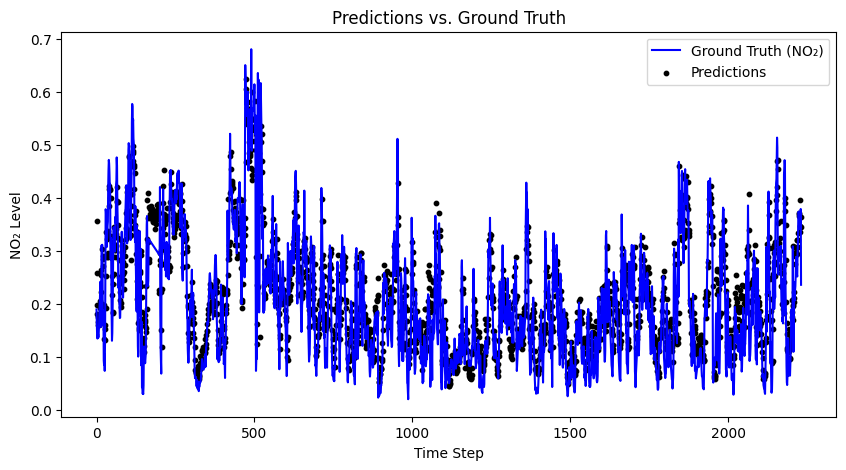

In [30]:
import torch
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
best_model_baseline.eval()

y_preds = []
y_trues = []

# Iterate through the test set and collect predictions & ground truth
with torch.no_grad():
    for batch in test_loader:
        x_test, y_true = batch  # Get input and ground truth
        x_test = x_test.to("cpu")  # Ensure data is on CPU if needed

        # Get predictions
        y_pred = best_model_baseline(x_test)

        # Store results
        y_preds.append(y_pred.cpu())
        y_trues.append(y_true.cpu())

# Convert lists to tensors
y_preds = torch.cat(y_preds, dim=0).numpy()
y_trues = torch.cat(y_trues, dim=0).numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_trues.flatten(), label="Ground Truth (NO₂)", linestyle="-", color="blue")
plt.scatter(range(len(y_preds.flatten())), y_preds.flatten(), label="Predictions", color="black", s=10)

plt.xlabel("Time Step")
plt.ylabel("NO₂ Level")
plt.title("Predictions vs. Ground Truth")
plt.legend()
#save the plot
plt.savefig(f"{RESULTS_PATH}/plots/{PLOT_FILENAME}")
plt.show()
